<a href="https://colab.research.google.com/github/RaffaNimir/Match-Up-recruiter-/blob/main/(3)_Match_Up_Recruiter_doc2vec_doc2ve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Getting** the user's PDF file and saving it to a .txt file 






In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install PyPDF2[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install PyMuPDF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing required modules
import PyPDF2
import gensim
import os
import fitz
import re
import pandas as pd
import numpy as np 
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import gensim.models
from gensim.similarities import Similarity
from gensim import matutils
from sklearn.metrics import roc_curve, auc
from numpy import argmax
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PyPDF2 import PdfReader
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler


#### Uploading the resumes; and transfering it to text lists. 

In [ ]:
# the merged dataset 
jobs = pd.read_csv("jobs.csv")

In [ ]:
jobs.shape

(16762, 7)

In [ ]:
# Drop NaN values
jobs.dropna(subset=['job_description'], inplace=True)

In [ ]:
# filter out the rows where job_description column has NaN values
jobs = jobs[jobs['job_description'].notna()]

In [ ]:
jobs.shape

(16754, 7)

In [ ]:
jobs.sample(10)

,job_ID,job_title,domain,company_name,location,job_description,salary
14332,14333,Data Analyst,NaN,PayPal,"Annapolis, MD","At PayPal (NASDAQ: PYPL), we believe that ever...",0
15268,15269,Data Analyst,NaN,Medix™,United States,"Job Title: Data AnalystType: Direct hire, or C...",80000.00\r\n -\r\n 11000...
7019,7020,"Intern Conversion - Data Scientist, Chief Anal...",Human-Resources,"IBM 26,438 reviews",Armonk,"Introduction\n\nAs a Data Scientist at IBM, yo...",0
473,474,Data Scientist,arts design and media,Robert Half Technology,Denver,Ref ID: 00610-0010853739 Classification: Datab...,0
8981,8982,"Data Scientist, (Staff or Principal)",Data Scientist,Realtor.com,Santa Clara,"Data Scientist, (Staff or Principal) at realto...",0
7149,7150,Senior Data Scientist,computer jobs,Collabera,Fort Lauderdale,"Fort Lauderdale, Florida\n\nSkills : Shell, E...",0
7353,7354,Data Scientist,Human-Resources,"AETNA 4,489 reviews - New York, NY 10016",New York,Description:\n\nLooking for opportunities to u...,0
11909,11910,Data Analyst- Remote,Retail,Fred Beans\n3.9,"Doylestown, PA",General Information\nJob Title:\nData Analyst-...,68K-89K (Glassdoor est.)
14648,14649,Entry-Level Data Analyst,NaN,The Federal Savings Bank,"Chicago, IL","The Federal Savings Bank, a national bank and ...",0
14200,14201,Data Analyst,NaN,PayPal,"Indiana, United States","At PayPal (NASDAQ: PYPL), we believe that ever...",0


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [ ]:
# load NLTK stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# text preprocessing function
def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    # tokenize the text into words
    tokens = word_tokenize(text)
    # remove stopwords
    tokens = [token for token in tokens if token not in nltk_stopwords]
    # remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # join the tokens back into text
    text = ' '.join(tokens)
    return text

In [ ]:
jobs['processed_text'] = jobs['job_description'].apply(preprocess_text)

In [ ]:
# Convert preprocessed job postings text into TaggedDocument objects
tagged_docs = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(jobs['processed_text'])]

In [ ]:
# Train a Doc2Vec model using the TaggedDocument objects
model = Doc2Vec(tagged_docs, vector_size=70, window=5, min_count=7, workers=3)

In [ ]:
model.save("doc2vec.model")

In [ ]:
# Infer vector representations for preprocessed job postings text
jobs['vector'] = jobs['job_description'].apply(lambda x: model.infer_vector(x.split()))

In [225]:
#importing the resume 
from google.colab import files
import os

# Prompt user to upload a file
pdf_file = files.upload()

# Save the file to disk
file_name = list(pdf_file.keys())[0]
file_path = os.path.join(os.getcwd(), file_name)
with open(file_path, 'wb') as f:
    f.write(pdf_file[file_name])

Saving 24.pdf to 24.pdf


In [227]:
import PyPDF2

# Open the PDF file in read-binary mode
with open('24.pdf', 'rb') as f:
    # Create a PDF reader object
    pdf_reader = PyPDF2.PdfReader(f)

    # Get the total number of pages in the PDF document
    num_pages = len(pdf_reader.pages)

    # Initialize an empty string to store the text
    text = ""

    # Loop through all the pages to extract text
    for i in range(num_pages):
        # Get the page object
        page = pdf_reader.pages[i]

        # Extract text from the page and append it to the string
        text += page.extract_text()

# Print the extracted text
print(text)

F i r s t  L a s t
Data Scientist
W O R K  E X P E R I E N C E
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Resume Worded,
London, United Kingdom
Education technology startup with 50+ employees and $100m+ annual revenue
Data Scientist
08/2021 – Present
●
Increased the usage and adoption of AI in 20+ departments by implementing
RESTful APIs to surface machine learning predictions.
●
Designed an anomaly detection framework for 10+ digital channels of RW,
reducing monthly loss avoidance by $23K.
●
Built an interactive dashboard for 120+ private sector clients to explore
employment and investment opportunities across 30+ geographies.
●
Developed a smart solution that reduced the number of manual data entries
from 89% to <5%, decreasing processing time from 20+ days to 48 minutes.
Polyhire,
London, United Kingdom
NYSE-listed recruitment and employer branding company
Statistical Programmer
10/2019 

In [228]:
text

"F i r s t  L a s t\nData Scientist\nW O R K  E X P E R I E N C E\n_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _\nResume Worded,\nLondon, United Kingdom\nEducation technology startup with 50+ employees and $100m+ annual revenue\nData Scientist\n08/2021 – Present\n●\nIncreased the usage and adoption of AI in 20+ departments by implementing\nRESTful APIs to surface machine learning predictions.\n●\nDesigned an anomaly detection framework for 10+ digital channels of RW,\nreducing monthly loss avoidance by $23K.\n●\nBuilt an interactive dashboard for 120+ private sector clients to explore\nemployment and investment opportunities across 30+ geographies.\n●\nDeveloped a smart solution that reduced the number of manual data entries\nfrom 89% to <5%, decreasing processing time from 20+ days to 48 minutes.\nPolyhire,\nLondon, United Kingdom\nNYSE-listed recruitment and employer branding company\nStatis

In [229]:
import re
import nltk
from nltk.corpus import stopwords

def cleaning_text(text, remove_stopwords=True):
    # removing links
    text = re.sub(r"http\S+", "", text)
    # removing numbers and special characters
    text = re.sub("[^A-Za-z]+", " ", text)
    # removing stopwords
    if remove_stopwords:
        # 1. create tokens
        tokens = nltk.word_tokenize(text)
        # 2. check if it's a stopword
        tokens = [w.lower().strip() for w in tokens if not w.lower() in stopwords.words("english")]
        # return a list of cleaned tokens
        return tokens
    else:
        # return cleaned text without removing stopwords
        return text

In [230]:
text = cleaning_text(text)

In [231]:
text

['f',
 'r',
 'l',
 'data',
 'scientist',
 'w',
 'r',
 'k',
 'e',
 'x',
 'p',
 'e',
 'r',
 'e',
 'n',
 'c',
 'e',
 'resume',
 'worded',
 'london',
 'united',
 'kingdom',
 'education',
 'technology',
 'startup',
 'employees',
 'annual',
 'revenue',
 'data',
 'scientist',
 'present',
 'increased',
 'usage',
 'adoption',
 'ai',
 'departments',
 'implementing',
 'restful',
 'apis',
 'surface',
 'machine',
 'learning',
 'predictions',
 'designed',
 'anomaly',
 'detection',
 'framework',
 'digital',
 'channels',
 'rw',
 'reducing',
 'monthly',
 'loss',
 'avoidance',
 'k',
 'built',
 'interactive',
 'dashboard',
 'private',
 'sector',
 'clients',
 'explore',
 'employment',
 'investment',
 'opportunities',
 'across',
 'geographies',
 'developed',
 'smart',
 'solution',
 'reduced',
 'number',
 'manual',
 'data',
 'entries',
 'decreasing',
 'processing',
 'time',
 'days',
 'minutes',
 'polyhire',
 'london',
 'united',
 'kingdom',
 'nyse',
 'listed',
 'recruitment',
 'employer',
 'branding',
 'com

In [232]:
# Infer the vector representation of the new text
text_vector = model.infer_vector(text)

In [233]:
from sklearn.metrics.pairwise import cosine_similarity

In [234]:
# Calculate the cosine similarity between my text vector and job vectors
cosine_similarities = cosine_similarity(text_vector.reshape(1, -1), jobs['vector'].tolist())[0]

# I will normalize the cosine similarity scores between 0 and 1 using min-max normalization
normalized_similarities = (cosine_similarities - np.min(cosine_similarities)) / (np.max(cosine_similarities) - np.min(cosine_similarities))

# I will retrieve the indices of the top 5 most similar jobs
top_job_indices = np.argsort(cosine_similarities)[-5:]

# I will create a DataFrame of the top 5 most similar jobs for my resume
top_jobs_df = pd.DataFrame({
    'job_ID': jobs.iloc[top_job_indices]['job_ID'].tolist(),
    'job_title': jobs.iloc[top_job_indices]['job_title'].tolist(),
    'job_description': jobs.iloc[top_job_indices]['job_description'].tolist(),
    'similarity_rank': [5, 4, 3, 2, 1],
    'similarity_score': cosine_similarities[top_job_indices],
    'normalized_score': normalized_similarities[top_job_indices]
})

In [235]:
#show results
top_jobs_df

,job_ID,job_title,job_description,similarity_rank,similarity_score,normalized_score
0,8482,Data Scientist - Must have Active Secret,Job Description \nInvent Your Future with CACI...,5,0.394414,0.956712
1,9070,Data Scientist - Mathematics/Computational mod...,"If you are a Data Scientist with experience, p...",4,0.402781,0.966906
2,11010,Spark AWS Data Engineer,Strong Programming experience with object-orie...,3,0.404779,0.969341
3,9023,Principal Data Scientist,Job Description: \n\nMastech Digital provides...,2,0.411344,0.977340
4,7715,Senior Data Scientist,JobID: 148718STRATEGIC STAFFING SOLUTIONS HAS ...,1,0.429942,1.000000


In [224]:
# I will calculate the Euclidean distance between my text vector and each job posting vector
jobs['similarity'] = jobs['vector'].apply(lambda x: euclidean_distances(text_vector.reshape(1, -1), x.reshape(1, -1))[0][0])

# I will normalize the similarity scores using min-max scaling
scaler = MinMaxScaler()
jobs['normalized_similarity'] = scaler.fit_transform(jobs[['similarity']])

# I will sort the job postings by the normalized similarity score and take the top 5
recommended_jobs = jobs.sort_values('normalized_similarity', ascending=False).head(5)

In [213]:
recommended_jobs

,job_ID,job_title,domain,company_name,location,job_description,salary,processed_text,vector,similarity,normalized_similarity
3049,3050,Data Scientist,Administrative,U.S. Federal Government,Arlington,Read what people are saying about working here...,0,read people saying working u.s. federal govern...,"[-0.68838567, 1.9429332, -0.76520306, -0.22064...",13.216901,1.000000
3475,3476,Data Scientist,Computer-or-internet,Systemart LLC,Jersey City,Read what people are saying about working here...,0,read people saying working role overview looki...,"[2.8367693, -0.4367335, -1.4075395, -1.5118828...",12.896173,0.956495
2752,2753,Operations Research Analyst (Data Scientist),Engineering/Architecture,US Department of the Army,Fort Huachuca,Read what people are saying about working here...,0,"read people saying working 89,478 116,319 year...","[-2.1810486, 1.3119495, -1.4779721, -0.5361737...",12.683969,0.927712
11519,11520,Forensic Scientist IV - DNA,Government,Arizona Department of Public Safety\n3.1,"Phoenix, AZ",Summary Statement\n\nThis recruitment will be ...,84K-156K (Glassdoor est.),summary statement recruitment used establish 1...,"[-0.5606456, 0.3076572, 1.8707539, -0.8708499,...",12.641044,0.921889
1734,1735,Data Scientist Technology Outreach Analyst,Engineering/Architecture,"The Kenjya-Trusant Group, LLC",Washington,Read what people are saying about working here...,0,read people saying working job description ken...,"[-0.93484324, -0.043452986, 0.79997927, 0.7504...",12.505527,0.903507


In [236]:
from sklearn.metrics.pairwise import manhattan_distances

In [237]:
# Calculate Manhattan distance between the text vector and each job posting vector
jobs['similarity'] = jobs['vector'].apply(lambda x: manhattan_distances(text_vector.reshape(1, -1), x.reshape(1, -1))[0][0])

# Normalize the similarity scores using min-max scaling
scaler = MinMaxScaler()
jobs['normalized_similarity'] = scaler.fit_transform(jobs[['similarity']])

# Sort job postings by normalized similarity score and take the top 5
recommended_jobs_m = jobs.sort_values('normalized_similarity', ascending=False).head(5)

In [238]:
#show result
recommended_jobs_m

,job_ID,job_title,domain,company_name,location,job_description,salary,processed_text,vector,similarity,normalized_similarity
3049,3050,Data Scientist,Administrative,U.S. Federal Government,Arlington,Read what people are saying about working here...,0,read people saying working u.s. federal govern...,"[-0.68838567, 1.9429332, -0.76520306, -0.22064...",93.318854,1.000000
11519,11520,Forensic Scientist IV - DNA,Government,Arizona Department of Public Safety\n3.1,"Phoenix, AZ",Summary Statement\n\nThis recruitment will be ...,84K-156K (Glassdoor est.),summary statement recruitment used establish 1...,"[-0.5606456, 0.3076572, 1.8707539, -0.8708499,...",85.802873,0.860898
6249,6250,Mathematical Statistician (Data Scientist),Computer-or-internet,US Department of Transportation 250 reviews - ...,Washington,Duties\n\nSummary\n\nYou will serve as a Mathe...,0,duties summary serve mathematical statistician...,"[-0.5125068, 0.620062, -1.1544874, -1.0787047,...",85.487089,0.855054
3245,3246,Marketing Data Scientist,Computer-or-internet,Drybar,Irvine,Read what people are saying about working here...,0,read people saying working drybar blow dry bar...,"[-1.0478843, 0.11784031, 1.8192437, 0.21077414...",84.858512,0.843421
2752,2753,Operations Research Analyst (Data Scientist),Engineering/Architecture,US Department of the Army,Fort Huachuca,Read what people are saying about working here...,0,"read people saying working 89,478 116,319 year...","[-2.1810486, 1.3119495, -1.4779721, -0.5361737...",84.323064,0.833511


In [239]:
resumes = pd.read_csv("pdf_texts.csv")

In [240]:
resumes['processed']= resumes['resume_text'].apply(cleaning_text)

In [241]:
def infer_vector(tokens):
    return model.infer_vector(tokens)

In [242]:
resumes['resume_vector'] = resumes['processed'].apply(infer_vector)

In [243]:
resumes.columns

Index(['filename', 'resume_text', 'resume_title ', 'processed',
       'resume_vector'],
      dtype='object')

In [244]:
resumes.reset_index(drop=True, inplace=True)
resumes.index = resumes.index + 1
resumes = resumes.drop('filename', axis=1)

In [245]:
resumes

,resume_text,resume_title,processed,resume_vector
1,First Last\nData Scientist\nData Scientist wi...,Data Scientist,"[first, last, data, scientist, data, scientist...","[-0.1436944, -0.6127889, -0.92129254, 0.994741..."
2,"FIRST LAST\nBay Area, California • +1-234-456-...",SQL Developer,"[first, last, bay, area, california, professio...","[-1.2959688, 0.5538425, -0.46455988, -0.792978..."
3,"FIRST LAST\nBay Area, California • +1-234-456-...",SQL Developer,"[first, last, bay, area, california, professio...","[-1.4921263, -0.048078008, -1.095918, -0.36224..."
4,"FIRST LAST\nBay Area, California • +1-234-456-...",PL/SQL Developer,"[first, last, bay, area, california, professio...","[-0.714325, 0.22797605, -0.8810139, -1.1740361..."
5,"FIRST LAST\nNew York, NY | P: +44 123456789 | ...",Data Analyst,"[first, last, new, york, ny, p, first, last, r...","[-1.0305847, 0.53178304, -0.1345266, 0.8550128..."
6,"First Last\nNew York, NY 10001 ∙ (212) 123-456...",Sr. Data Scientist,"[first, last, new, york, ny, first, last, resu...","[-1.8457545, -0.6392265, -0.6426954, 0.993585,..."
7,FIRST LAST\nData Science Manager\nNew York Cit...,Data Science Manager,"[first, last, data, science, manager, new, yor...","[-1.1381879, -0.124249086, -0.19581014, 0.9840..."
8,"FIRST LAST\nSQL Analyst\nNew York City, NY 100...",SQL Analyst,"[first, last, sql, analyst, new, york, city, n...","[-0.17394117, 0.09239025, -0.35871813, -0.3653..."
9,"FIRST LAST\nBay Area, California • +1-234-456-...",Data Scientist,"[first, last, bay, area, california, professio...","[-1.337409, -0.50841576, 0.10312792, 0.8413836..."
10,KINDERGARTEN TEACHER\nProfessional Summary\nEn...,Kindergarten teacher,"[kindergarten, teacher, professional, summary,...","[-1.4153826, 0.027761329, 0.4529341, 1.8389263..."


In [246]:
jobs.columns

Index(['job_ID', 'job_title', 'domain', 'company_name', 'location',
       'job_description', 'salary', 'processed_text', 'vector', 'similarity',
       'normalized_similarity'],
      dtype='object')

In [247]:
resumes = resumes.reset_index(drop=True)

In [248]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create an empty dataframe to store the results
result_df = pd.DataFrame(columns=['resume_index', 'resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match', 'status'])

# Step 2: Iterate over each row in the resumes dataframe
for resume_index in range(len(resumes)):
    
    # Get the current resume's vector representation
    resume_vector = resumes['resume_vector'][resume_index]
    
    # Calculate the cosine similarity between the current resume and all jobs
    similarities = cosine_similarity(resume_vector.reshape(1, -1), jobs['vector'].tolist())
    
    # Get the indices of the top 5 highest similarity scores
    top_indices = similarities.argsort()[0][-5:][::-1]
    
    # Step 3: Iterate over the top 5 similar jobs and add them to the result dataframe
    for rank, job_index in enumerate(top_indices):
        similarity = similarities[0][job_index]
        normalized_similarity =(similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
     
        if (normalized_similarity > 0.80).any():
            match = 1
        else:
            match = 0

        if resume_index < 10:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'
        elif resume_index < 20:
            if match == 1:
                status = 'irrelevant'
            else:
                status = 'relevant'
        else:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'   
        
        job = jobs.iloc[job_index]
        result_df = result_df.append({
            'resume_index': resume_index,
            'resume_title': resumes['resume_title '][resume_index],
            'resume_text': resumes['resume_text'][resume_index],
            'job_id': job['job_ID'],
            'job_title': job['job_title'],
            'job_description': job['job_description'],
            'similarity': similarity,
            'normalized_similarity': normalized_similarity,
            'similarity_rank': rank+1,
            'match': match,
            'status': status
        }, ignore_index=True)

# Step 6: Print the result dataframe
result = result_df.groupby('resume_index').apply(lambda x: x[['resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match','status']].sort_values('similarity_rank', ascending=False))

<ipython-input-248-788241c95e73>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-248-788241c95e73>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-248-788241c95e73>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-248-788241c95e73>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-248-788241c95e73>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = resu

In [249]:
result

resume_title  \
resume_index                              
0            4           Data Scientist   
             3           Data Scientist   
             2           Data Scientist   
             1           Data Scientist   
             0           Data Scientist   
...                                 ...   
29           149  Senior Data Scientist   
             148  Senior Data Scientist   
             147  Senior Data Scientist   
             146  Senior Data Scientist   
             145  Senior Data Scientist   

                                                        resume_text job_id  \
resume_index                                                                 
0            4    First Last\nData Scientist\nData Scientist  wi...  10328   
             3    First Last\nData Scientist\nData Scientist  wi...  13627   
             2    First Last\nData Scientist\nData Scientist  wi...   4051   
             1    First Last\nData Scientist\nData Scientist  wi...   5442   
             0    First Last\nData Scientist\nData Scientist  wi...   8007   
...                                                             ...    ...   
29           149  First Last\nSenior Data Scientist\nPhoenix, Ar...  13110   
             148  First Last\nSenior Data Scientist\nPhoenix, Ar...   1488   
             147  First Last\nSenior Data Scientist\nPhoenix, Ar...  10306   
             146  First Last\nSenior Data Scientist\nPhoenix, Ar...   9977   
             145  First Last\nSenior Data Scientist\nPhoenix, Ar...   2610   

                                                          job_title  \
resume_index                                                          
0            4                                Senior Data Scientist   
             3               Director of Development & Data Science   
             2                                       Data Scientist   
             1                                       Data Scientist   
             0    Sr. to Lead Data Scientist (IoT startup, up to...   
...                                                             ...   
29           149               Senior Data Scientist - Optimization   
             148                              Senior Data Scientist   
             147                                       Data Analyst   
             146                        Data Scientist - Boston, MA   
             145                    Senior Marketing Data Scientist   

                                                    job_description  \
resume_index                                                          
0            4    Hinge is seeking a data scientist to oversee i...   
             3    Position:\n\nDirector of Development & Data Sc...   
             2    ROMPH & POU is not a typical Advertising & Mar...   
             1    ROMPH & POU is not a typical Advertising & Mar...   
             0    Skyrocket Ventures is a recruiting firm for hu...   
...                                                             ...   
29           149  ENERGY INDUSTRY TRANSFORMATION\n\nThe trillion...   
             148  Read what people are saying about working here...   
             147  Gainful is changing the way people shop for nu...   
             146  The Data Scientist will collaborate with engin...   
             145  Read what people are saying about working here...   

                  similarity  \
resume_index                   
0            4      0.391590   
             3      0.392809   
             2      0.402333   
             1      0.411731   
             0      0.425596   
...                      ...   
29           149    0.412338   
             148    0.416098   
             147    0.420645   
             146    0.443424   
             145    0.449432   

                                              normalized_similarity  \
resume_index                                                          
0            4    [[0.47913656, 0.460703, 0.6

In [250]:
grouped_df = result_df.groupby("resume_index")
group_0 = grouped_df.get_group(0)

In [251]:
group_0

,resume_index,resume_title,resume_text,job_id,job_title,job_description,similarity,normalized_similarity,similarity_rank,match,status
0,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,8007,"Sr. to Lead Data Scientist (IoT startup, up to...",Skyrocket Ventures is a recruiting firm for hu...,0.425596,"[[0.47913656, 0.460703, 0.6537338, 0.6861113, ...",1,1,relevant
1,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,5442,Data Scientist,ROMPH & POU is not a typical Advertising & Mar...,0.411731,"[[0.47913656, 0.460703, 0.6537338, 0.6861113, ...",2,1,relevant
2,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,4051,Data Scientist,ROMPH & POU is not a typical Advertising & Mar...,0.402333,"[[0.47913656, 0.460703, 0.6537338, 0.6861113, ...",3,1,relevant
3,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,13627,Director of Development & Data Science,Position:\n\nDirector of Development & Data Sc...,0.392809,"[[0.47913656, 0.460703, 0.6537338, 0.6861113, ...",4,1,relevant
4,0,Data Scientist,First Last\nData Scientist\nData Scientist wi...,10328,Senior Data Scientist,Hinge is seeking a data scientist to oversee i...,0.391590,"[[0.47913656, 0.460703, 0.6537338, 0.6861113, ...",5,1,relevant


In [252]:
precision = len(result[result['status']=="relevant"]) / len(result)
print("Precision for cosine similarity fitted jobs is : {}".format(round(precision, 2)))

Precision for cosine similarity fitted jobs is : 0.67


In [253]:
recall =  len(result[result['status']=="relevant"])/ 100 

print("recall for cosine similarity fitted jobs is :{}".format(recall))


recall for cosine similarity fitted jobs is :1.0


In [254]:
# from precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 score:", round(f1_score,5))

F1 score: 0.8


In [255]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Step 1: Create an empty dataframe to store the results
result_df = pd.DataFrame(columns=['resume_index', 'resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match', 'status'])

# Step 2: Iterate over each row in the resumes dataframe
for resume_index in range(len(resumes)):
    
    # Get the current resume's vector representation
    resume_vector = resumes['resume_vector'][resume_index]
    
    # Calculate the Euclidean distance between the current resume and all jobs
    distances = euclidean_distances(resume_vector.reshape(1, -1), jobs['vector'].tolist())
    
    # Get the indices of the top 5 lowest distance scores
    top_indices = np.argsort(-distances)[0][:5]
    
    # Step 3: Iterate over the top 5 similar jobs and add them to the result dataframe
    for rank, job_index in enumerate(top_indices):
        similarity = 1 / (1 + distances[0][job_index])
        normalized_similarity =(similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
     
        if (normalized_similarity > 0.80).any():
            match = 1
        else:
            match = 0

        if resume_index < 10:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'
        elif resume_index < 20:
            if match == 1:
                status = 'irrelevant'
            else:
                status = 'relevant'
        else:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'   
        
        job = jobs.iloc[job_index]
        result_df = result_df.append({
            'resume_index': resume_index,
            'resume_title': resumes['resume_title '][resume_index],
            'resume_text': resumes['resume_text'][resume_index],
            'job_id': job['job_ID'],
            'job_title': job['job_title'],
            'job_description': job['job_description'],
            'similarity': similarity,
            'normalized_similarity': normalized_similarity,
            'similarity_rank': rank+1,
            'match': match,
            'status': status
        }, ignore_index=True)

# Step 6: Print the result dataframe
result_euclidian = result_df.groupby('resume_index').apply(lambda x: x[['resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match','status']].sort_values('similarity_rank', ascending=False))

<ipython-input-255-ade09a18b448>:23: RuntimeWarning: invalid value encountered in double_scalars
  normalized_similarity =(similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
<ipython-input-255-ade09a18b448>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-255-ade09a18b448>:23: RuntimeWarning: invalid value encountered in double_scalars
  normalized_similarity =(similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
<ipython-input-255-ade09a18b448>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-255-ade09a18b448>:23: RuntimeWarning: invalid value encountered in double_scalars
  normalized_similarity =(similarity - np.min(similarity)) / (np.max(similarity) - np.min(similar

In [256]:
precision_euclidian = len(result_euclidian[result_euclidian['status']=="relevant"]) / len(result_euclidian)
print("Precision for euclidian similarity fitted jobs is : {}".format(round(precision_euclidian, 2)))

Precision for euclidian similarity fitted jobs is : 0.33


In [257]:
recall_euclidian =  len(result_euclidian[result_euclidian['status']=="relevant"])/ 100 

print("recall for euclidian similarity fitted jobs is :{}".format(recall_euclidian))


recall for euclidian similarity fitted jobs is :0.5


In [258]:
# from precision and recall
f1_score_euclidian = 2 * (precision_euclidian * recall_euclidian) / (precision_euclidian + recall_euclidian)
print("F1 score:", f1_score_euclidian)

F1 score: 0.4


In [259]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances

# Step 1: Create an empty dataframe to store the results
result_df = pd.DataFrame(columns=['resume_index', 'resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match', 'status'])

# Step 2: Iterate over each row in the resumes dataframe
for resume_index in range(len(resumes)):
    
    # Get the current resume's vector representation
    resume_vector = resumes['resume_vector'][resume_index]
    
    # Calculate the Manhattan distance between the current resume and all jobs
    distances = manhattan_distances(resume_vector.reshape(1, -1), jobs['vector'].tolist())
    
    # Get the indices of the top 5 lowest distance scores
    top_indices = np.argsort(distances)[0][:5]
    
    # Step 3: Iterate over the top 5 similar jobs and add them to the result dataframe
    for rank, job_index in enumerate(top_indices):
        similarity = -distances[0][job_index] + 1
        normalized_similarity = (similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
     
        if (normalized_similarity > 0.80).any():
            match = 1
        else:
            match = 0

        if resume_index < 10:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'
        elif resume_index < 20:
            if match == 1:
                status = 'irrelevant'
            else:
                status = 'relevant'
        else:
            if match == 1:
                status = 'relevant'
            else:
                status = 'irrelevant'   
        
        job = jobs.iloc[job_index]
        result_df = result_df.append({
            'resume_index': resume_index,
            'resume_title': resumes['resume_title '][resume_index],
            'resume_text': resumes['resume_text'][resume_index],
            'job_id': job['job_ID'],
            'job_title': job['job_title'],
            'job_description': job['job_description'],
            'similarity': similarity,
            'normalized_similarity': normalized_similarity,
            'similarity_rank': rank+1,
            'match': match,
            'status': status
        }, ignore_index=True)

# Step 6: Print the result dataframe
result_manhattan = result_df.groupby('resume_index').apply(lambda x: x[['resume_title', 'resume_text', 'job_id', 'job_title', 'job_description', 'similarity', 'normalized_similarity', 'similarity_rank', 'match','status']].sort_values('similarity_rank', ascending=False))

<ipython-input-259-8feaa941b325>:23: RuntimeWarning: invalid value encountered in double_scalars
  normalized_similarity = (similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
<ipython-input-259-8feaa941b325>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-259-8feaa941b325>:23: RuntimeWarning: invalid value encountered in double_scalars
  normalized_similarity = (similarity - np.min(similarity)) / (np.max(similarity) - np.min(similarity))
<ipython-input-259-8feaa941b325>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-259-8feaa941b325>:23: RuntimeWarning: invalid value encountered in double_scalars
  normalized_similarity = (similarity - np.min(similarity)) / (np.max(similarity) - np.min(simi

In [260]:
precision_manhattan = len(result_manhattan[result_manhattan['status']=="relevant"]) / len(result_manhattan)
print("Precision for manhattan similarity fitted jobs is : {}".format(round(precision_manhattan, 2)))

Precision for manhattan similarity fitted jobs is : 0.33


In [261]:
recall_manhattan =  len(result_manhattan[result_manhattan['status']=="relevant"])/ 100 

print("recall for manhattan similarity fitted jobs is :{}".format(recall_manhattan))


recall for manhattan similarity fitted jobs is :0.5


In [262]:
f1_score_manhattan = 2 * (precision_manhattan * recall_manhattan) / (precision_manhattan + recall_manhattan)
print("F1 score:", f1_score_manhattan)

F1 score: 0.4


In [263]:
comparision = pd.DataFrame({'Precision':[precision,precision_euclidian,precision_manhattan], 'Recall':[recall,recall_euclidian,recall_manhattan], 'F1-score':[f1_score, f1_score_euclidian,f1_score_manhattan]})

In [264]:
import matplotlib as plt

Text(0.5, 1.0, 'Precision-Recall & F1-score for Cosine, Euclidean, and Manhattan similarities')

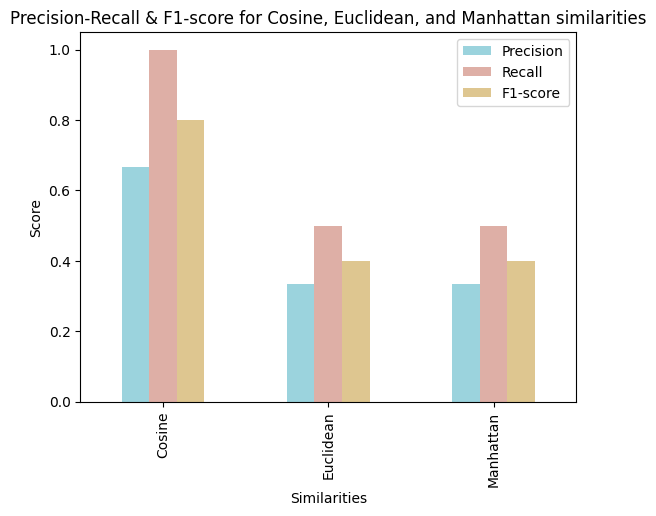

In [265]:
# Define the column names
columns = ['Cosine', 'Euclidean', 'Manhattan']

# Create a bar plot with three colors
colors = ['#9BD3DD', '#DEAFA6', '#DEC690']
ax = comparision.plot(kind='bar', color=colors)

# Customize the plot
ax.set_xlabel('Similarities')
ax.set_ylabel('Score')
ax.set_xticklabels(columns)  # Add x-axis column names
ax.set_title('Precision-Recall & F1-score for Cosine, Euclidean, and Manhattan similarities')

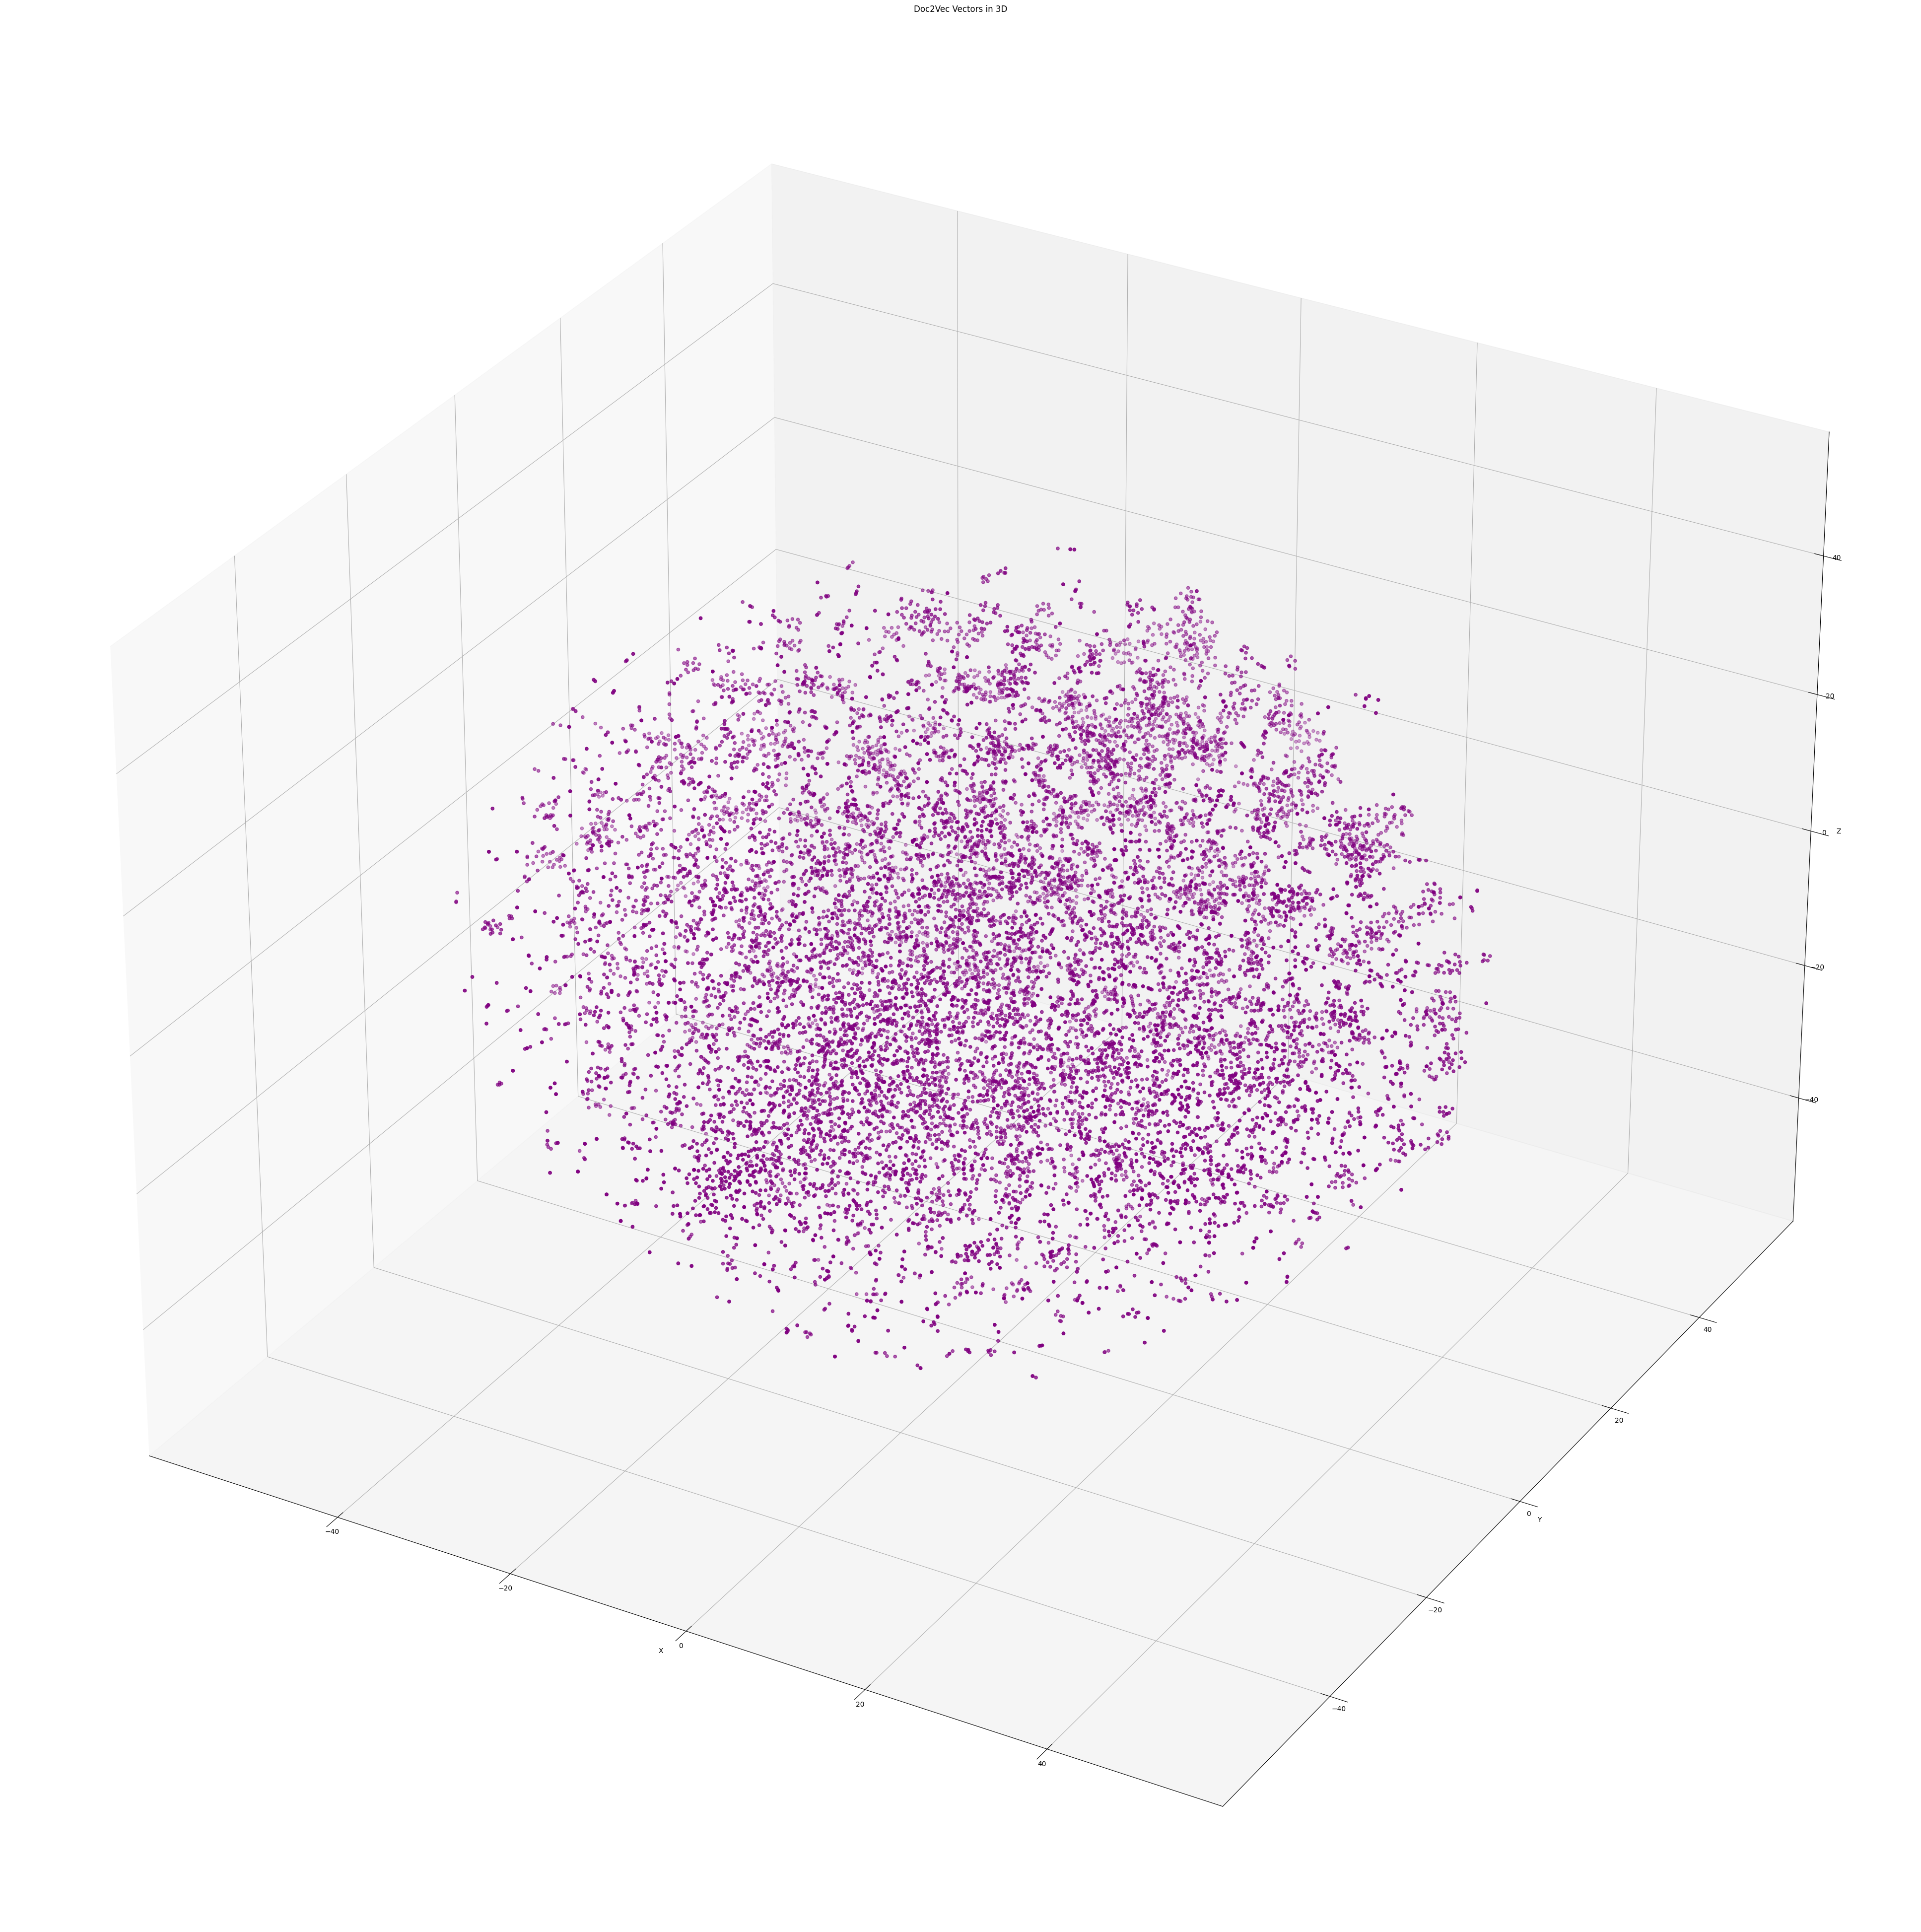

In [266]:
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the trained Doc2Vec model
model = Doc2Vec.load('doc2vec.model')

# Get the document vectors
vectors = model.dv.vectors

# Project the vectors to 3D using t-SNE
tsne = TSNE(n_components=3, random_state=0)
projected_vectors = tsne.fit_transform(vectors)

# Create a larger plot and set the color to purple
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected_vectors[:, 0], projected_vectors[:, 1], projected_vectors[:, 2], color='purple')

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Doc2Vec Vectors in 3D')

# Show the plot
plt.show()